# Imports and Setup

In [ ]:
import os, random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


pygame 2.6.1 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Snake Environment Definition


In [3]:
class SnakeEnv:
    def __init__(self, width=10, height=10, block_size=20):
        pygame.init()
        self.width, self.height, self.block = width, height, block_size
        # use self.block, not block
        self.display = pygame.Surface((self.width * self.block,
                                       self.height * self.block))
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.direction = (1, 0)
        self.snake = [(self.width//2, self.height//2)]
        self._place_food()
        self.done, self.score = False, 0
        return self._get_obs()


    def _place_food(self):
        while True:
            self.food = (random.randrange(self.width),
                         random.randrange(self.height))
            if self.food not in self.snake:
                break

    def _get_obs(self):
        head_x, head_y = self.snake[0]
        dir_x, dir_y = self.direction
        food_x, food_y = self.food

        # Danger detection: front, right, left
        def danger_at(offset):
            dx, dy = offset
            new_x, new_y = head_x + dx, head_y + dy
            return int(
                new_x < 0 or new_x >= self.width or
                new_y < 0 or new_y >= self.height or
                (new_x, new_y) in self.snake
            )

        left  = (-dir_y, dir_x)
        right = (dir_y, -dir_x)
        front = (dir_x, dir_y)

        danger = [
            danger_at(front),
            danger_at(right),
            danger_at(left)
        ]

        # Food direction (relative)
        food_dx = int(np.sign(food_x - head_x))
        food_dy = int(np.sign(food_y - head_y))

        # Normalize direction
        dir_features = [
            int(dir_x == 1), int(dir_x == -1),
            int(dir_y == 1), int(dir_y == -1)
        ]

        return np.array(danger + dir_features + [food_dx, food_dy], dtype=np.float32)



    def step(self, action):
        dirs = [(-1,0),(0,1),(1,0),(0,-1)]
        new_dir = dirs[action]
        if (new_dir[0]==-self.direction[0] and
            new_dir[1]==-self.direction[1]):
            new_dir = self.direction
        self.direction = new_dir

        head = (self.snake[0][0]+new_dir[0],
                self.snake[0][1]+new_dir[1])
        if (not 0<=head[0]<self.width or
            not 0<=head[1]<self.height or
            head in self.snake):
            self.done = True
            return self._get_obs(), -10, True, {}

        self.snake.insert(0, head)
        if head == self.food:
            reward, self.score = 10, self.score+1
            self._place_food()
        else:
            reward = -0.1
            self.snake.pop()

        return self._get_obs(), reward, False, {}

    # Inside your SnakeEnv class, overwrite render() with:

    def render(self):
        """
        Return a (H_px, W_px, 3) uint8 image of the game:
         - snake in green, food in red, background black.
        """
        H_px = self.height * self.block
        W_px = self.width  * self.block
        frame = np.zeros((H_px, W_px, 3), dtype=np.uint8)

        # Draw snake
        for x, y in self.snake:
            y0, y1 = y*self.block, (y+1)*self.block
            x0, x1 = x*self.block, (x+1)*self.block
            frame[y0:y1, x0:x1] = np.array([0,255,0], dtype=np.uint8)

        # Draw food
        fx, fy = self.food
        y0, y1 = fy*self.block, (fy+1)*self.block
        x0, x1 = fx*self.block, (fx+1)*self.block
        frame[y0:y1, x0:x1] = np.array([255,0,0], dtype=np.uint8)

        return frame


# Replay Memory (for DQN)


In [4]:
env = SnakeEnv()


# Define a transition tuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Instantiate and test
memory = ReplayMemory(capacity=1000)


# DQN Network Definition


In [5]:
import torch.nn as nn

state_dim  = len(env.reset()) # flattened grid size
action_dim = 4                         # up, right, down, left

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
# Initialize target to match policy
target_net.load_state_dict(policy_net.state_dict())


<All keys matched successfully>

#  DQN: Action Selection & Q-Network Update


In [6]:
# Cell 8 – Action Selection, Optimizer, and DQN Update

import torch.optim as optim
import torch.nn.functional as F

# ε‑greedy action selection
def select_action_dqn(state, eps):
    """
    state: 1D numpy array of length state_dim
    eps: float between 0 and 1
    returns: int action in [0, action_dim)
    """
    if random.random() < eps:
        return random.randrange(action_dim)
    # otherwise pick best Q-value action
    state_v = torch.from_numpy(state).unsqueeze(0).to(device)   # shape [1, state_dim]
    with torch.no_grad():
        q_vals = policy_net(state_v)                            # shape [1, action_dim]
    return int(q_vals.argmax(dim=1).item())

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

# Single DQN update step
def optimize_dqn_step(batch_size, gamma):
    if len(memory) < batch_size:
        return

    # Sample a batch
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Convert to tensors
    states      = torch.tensor(batch.state,      dtype=torch.float32, device=device)
    actions     = torch.tensor(batch.action,     dtype=torch.int64,   device=device).unsqueeze(1)
    rewards     = torch.tensor(batch.reward,     dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
    dones       = torch.tensor(batch.done,       dtype=torch.float32, device=device).unsqueeze(1)

    # Current Q values
    q_values = policy_net(states).gather(1, actions)   # shape [batch_size, 1]

    # Next state values from target network
    next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q = rewards + gamma * next_q * (1.0 - dones)

    # Compute loss and backprop
    loss = F.mse_loss(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [7]:
config_dqn = {
    "gamma": 0.99,
    "batch_size": 64,
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 5000,
    "target_update": 10,
    "num_episodes": 1000,
    "ckpt_path": os.path.join("checkpoints", "dqn_snake.pth")
}
os.makedirs("checkpoints", exist_ok=True)


# Save and Load DQN Checkpoints


In [8]:
def save_checkpoint(model, optimizer, path):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, path)

def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f"Loaded checkpoint from {path}")
    else:
        print("No checkpoint found.")


# DQN Training Loop (Short Test Run)


In [9]:
episode_rewards = []
steps_done = 0

def get_epsilon(step):
    return config_dqn["eps_end"] + (config_dqn["eps_start"] - config_dqn["eps_end"]) * \
           np.exp(-1. * step / config_dqn["eps_decay"])

for ep in range(1, 21):  # short test run
    state = env.reset()
    total_reward = 0
    while True:
        eps = get_epsilon(steps_done)
        action = select_action_dqn(state, eps)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        optimize_dqn_step(config_dqn["batch_size"], config_dqn["gamma"])
        state = next_state
        total_reward += reward
        steps_done += 1
        if done:
            break
    episode_rewards.append(total_reward)
    if ep % config_dqn["target_update"] == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {ep:2d} | Reward: {total_reward:.2f}")

save_checkpoint(policy_net, optimizer, config_dqn["ckpt_path"])


Episode  1 | Reward: -11.00
Episode  2 | Reward: -10.60
Episode  3 | Reward: -10.50
Episode  4 | Reward: -12.40
Episode  5 | Reward: -2.20
Episode  6 | Reward: -10.70
Episode  7 | Reward: -12.00
Episode  8 | Reward: -1.90
Episode  9 | Reward: -10.60


/var/folders/5t/35w5sh2n3r196t69kjv4ldm00000gn/T/ipykernel_6756/1326463507.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
  states      = torch.tensor(batch.state,      dtype=torch.float32, device=device)


Episode 10 | Reward: -10.60
Episode 11 | Reward: -13.00
Episode 12 | Reward: -10.70
Episode 13 | Reward: -11.00
Episode 14 | Reward: -12.80
Episode 15 | Reward: -11.70
Episode 16 | Reward: -11.10
Episode 17 | Reward: -12.00
Episode 18 | Reward: -0.80
Episode 19 | Reward: -11.20
Episode 20 | Reward: -11.40


# DQN Training Reward Plot


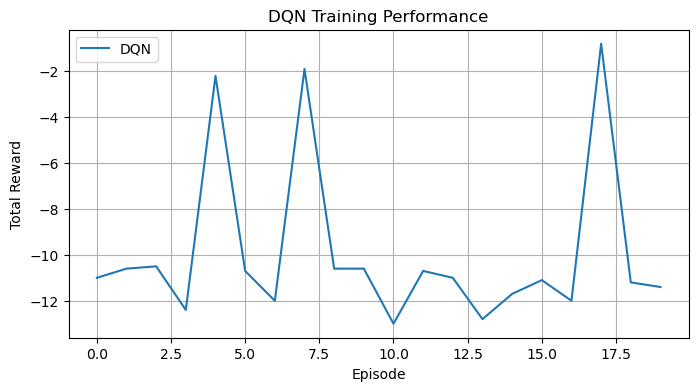

In [10]:
def plot_rewards(rewards, label="DQN", title="DQN Training Performance"):
    plt.figure(figsize=(8, 4))
    plt.plot(rewards, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_rewards(episode_rewards)


In [11]:
#Cell 13

def evaluate_policy_dqn(net, env, n_episodes=20, max_steps=500):
    net.eval()
    scores = []
    with torch.no_grad():
        for _ in range(n_episodes):
            state = env.reset()
            total = 0
            done = False
            steps = 0
            while not done and steps < max_steps:
                state_v = torch.from_numpy(state).float().unsqueeze(0).to(device)
                q_vals = net(state_v)
                action = q_vals.argmax(dim=1).item()
                state, reward, done, _ = env.step(action)
                total += reward
                steps += 1
            scores.append(total)
    net.train()
    return scores

eval_env = SnakeEnv()
eval_scores = evaluate_policy_dqn(policy_net, eval_env, n_episodes=20)
print(f"Eval (20 eps): avg={np.mean(eval_scores):.2f} ± {np.std(eval_scores):.2f}")


Eval (20 eps): avg=-8.01 ± 4.60


# Full DQN Training Loop


In [16]:
def train_dqn_full(env, policy_net, target_net, memory, optimizer, config):
    episode_rewards = []
    steps_done = 0
    max_steps = 500

    for ep in range(1, config["num_episodes"] + 1):
        state = env.reset()
        total_reward = 0

        for t in range(max_steps):
            eps = get_epsilon(steps_done)
            action = select_action_dqn(state, eps)
            next_state, reward, done, _ = env.step(action)

            memory.push(state, action, reward, next_state, done)
            optimize_dqn_step(config["batch_size"], config["gamma"])

            state = next_state
            total_reward += reward
            steps_done += 1

            if done:
                break

        episode_rewards.append(total_reward)

        if ep % config["target_update"] == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if ep % 50 == 0:
            avg = np.mean(episode_rewards[-50:])
            print(f"Episode {ep:3d} | Avg of last 50: {avg:.2f}")


    save_checkpoint(policy_net, optimizer, config["ckpt_path"])
    return episode_rewards

episode_rewards = train_dqn_full(env, policy_net, target_net, memory, optimizer, config_dqn)


Episode  50 | Avg of last 50): -7.77
Episode 100 | Avg of last 50): -4.86
Episode 150 | Avg of last 50): -4.01
Episode 200 | Avg of last 50): 1.47
Episode 250 | Avg of last 50): 12.80
Episode 300 | Avg of last 50): 12.03
Episode 350 | Avg of last 50): 29.12
Episode 400 | Avg of last 50): 56.36
Episode 450 | Avg of last 50): 97.24
Episode 500 | Avg of last 50): 120.92
Episode 550 | Avg of last 50): 135.45
Episode 600 | Avg of last 50): 104.57
Episode 650 | Avg of last 50): 121.62
Episode 700 | Avg of last 50): 98.45
Episode 750 | Avg of last 50): 129.11
Episode 800 | Avg of last 50): 130.81
Episode 850 | Avg of last 50): 129.41
Episode 900 | Avg of last 50): 132.27
Episode 950 | Avg of last 50): 147.64
Episode 1000 | Avg of last 50): 132.33


# Rolling Average Reward Plot


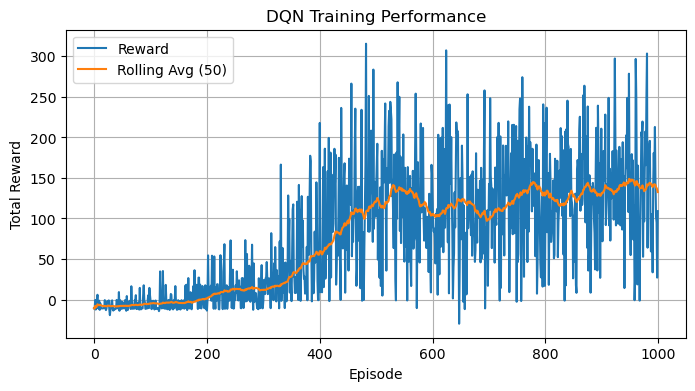

In [17]:
def plot_rolling_average(rewards, window=50, label="DQN", title="Rolling Average Reward"):
    rolling_avg = [np.mean(rewards[max(0, i - window):i+1]) for i in range(len(rewards))]

    plt.figure(figsize=(8, 4))
    plt.plot(rewards, label="Reward")
    plt.plot(rolling_avg, label=f"Rolling Avg ({window})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_average(episode_rewards, label="DQN", title="DQN Training Performance")


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

In [ ]:
class RolloutBuffer:
    def __init__(self):
        self.states     = []
        self.actions    = []
        self.log_probs  = []
        self.rewards    = []
        self.dones      = []
        self.values     = []

    def clear(self):
        self.__init__()


In [ ]:
ppo_config = {
    "gamma":        0.99,
    "gae_lambda":   0.95,
    "clip_eps":     0.2,
    "lr":           2.5e-4,
    "epochs":       4,
    "batch_size":   64,
    "update_steps": 2048
}

def compute_gae(rewards, values, dones, gamma, lam):
    advantages = []
    gae = 0
    values = values + [0]  # bootstrap
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return advantages


In [ ]:
def collect_trajectory(env, model, buffer, steps, max_steps=500):
    state = env.reset()
    for _ in range(steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, done, _ = env.step(action.item())

        buffer.states.append(state)
        buffer.actions.append(action.item())
        buffer.log_probs.append(dist.log_prob(action).item())
        buffer.rewards.append(reward)
        buffer.dones.append(done)
        buffer.values.append(value.item())

        state = next_state
        if done:
            state = env.reset()


In [ ]:
def ppo_update(model, optimizer, buffer, config):
    # Convert to tensors
    states = torch.tensor(buffer.states, dtype=torch.float32).to(device)
    actions = torch.tensor(buffer.actions).to(device)
    old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
    rewards = buffer.rewards
    dones = buffer.dones
    values = buffer.values

    # Compute advantages and returns
    advantages = compute_gae(rewards, values, dones,
                             config["gamma"], config["gae_lambda"])
    returns = torch.tensor([a + v for a, v in zip(advantages, values)],
                           dtype=torch.float32).to(device)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # PPO update over multiple epochs
    for _ in range(config["epochs"]):
        for i in range(0, len(states), config["batch_size"]):
            s_batch = states[i:i+config["batch_size"]]
            a_batch = actions[i:i+config["batch_size"]]
            r_batch = returns[i:i+config["batch_size"]]
            adv_batch = advantages[i:i+config["batch_size"]]
            logp_old_batch = old_log_probs[i:i+config["batch_size"]]

            probs, values = model(s_batch)
            dist = torch.distributions.Categorical(probs)
            logp = dist.log_prob(a_batch)
            entropy = dist.entropy().mean()

            ratio = torch.exp(logp - logp_old_batch)
            clipped = torch.clamp(ratio, 1 - config["clip_eps"], 1 + config["clip_eps"]) * adv_batch
            loss_clip = -torch.min(ratio * adv_batch, clipped).mean()
            loss_value = F.mse_loss(values.squeeze(), r_batch)
            loss = loss_clip + 0.5 * loss_value - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [ ]:
env = SnakeEnv()
buffer = RolloutBuffer()
model = ActorCritic(state_dim=len(env.reset()), action_dim=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=ppo_config["lr"])

reward_history = []

def evaluate_policy(net, env, n_episodes=10, max_steps=500):
    net.eval()
    scores = []
    with torch.no_grad():
        for _ in range(n_episodes):
            state = env.reset()
            total = 0
            done = False
            steps = 0
            while not done and steps < max_steps:
                state_v = torch.from_numpy(state).float().unsqueeze(0).to(device)
                probs, _ = net(state_v)
                action = probs.argmax(dim=1).item()
                state, reward, done, _ = env.step(action)
                total += reward
                steps += 1
            scores.append(total)
    net.train()
    return scores

for update in range(1, 101):  # 100 updates
    collect_trajectory(env, model, buffer, ppo_config["update_steps"])
    ppo_update(model, optimizer, buffer, ppo_config)
    buffer.clear()

    # Evaluate average reward over 10 episodes
    eval_scores = evaluate_policy(model, env, n_episodes=10)
    avg_reward = np.mean(eval_scores)
    reward_history.append(avg_reward)
    print(f"Update {update:3d} | Avg Reward: {avg_reward:.2f}")


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(reward_history, label="Eval Avg Reward")
plt.title("PPO Performance Over Time")
plt.xlabel("Update")
plt.ylabel("Average Reward")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
env = SnakeEnv()
state_dim = len(env.reset())
action_dim = 4

model = ActorCritic(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

a2c_rewards = []
num_episodes = 500
gamma = 0.99

for ep in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_state, reward, done, _ = env.step(action.item())
        next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
        _, next_value = model(next_state_tensor)

        # Compute target and advantage
        target = reward + (1 - done) * gamma * next_value.item()
        advantage = target - value.item()

        # Compute loss
        policy_loss = -log_prob * advantage
        value_loss = F.mse_loss(value, torch.tensor([[target]], device=device))
        loss = policy_loss + value_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        total_reward += reward

    a2c_rewards.append(total_reward)
    if ep % 10 == 0:
        avg = np.mean(a2c_rewards[-10:])
        print(f"Episode {ep:3d} | Reward: {total_reward:.2f} | Avg(10): {avg:.2f}")


In [ ]:
window = 50
rolling_avg = [np.mean(a2c_rewards[max(0, i-window):i+1]) for i in range(len(a2c_rewards))]
plt.plot(rolling_avg, label="Rolling Avg")
